In [155]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

In [2]:
from transform import combine_tsv_files

# CNV

In [18]:
# Harmonic mean genomic variable.
X_train_hm, y_train_hm = combine_tsv_files(
    "output/train__harmonic_mean__Allele Fraction.tsv",
    "output/train__harmonic_mean__CNV Score.tsv",
)
Xy = X_train_hm.merge(y_train_hm, left_index=True, right_index=True)

In [48]:
cnv_columns = ['EGFR_cnv', 'ERBB2_cnv', 'MET_cnv']
Xy[r'H'] = Xy[cnv_columns].sum(axis=1).apply(lambda x: r'$H^{\mathrm{CNV}}=0$' if x == 0 else r'$H^{\mathrm{CNV}}\neq 0$')

<Figure size 288x216 with 0 Axes>

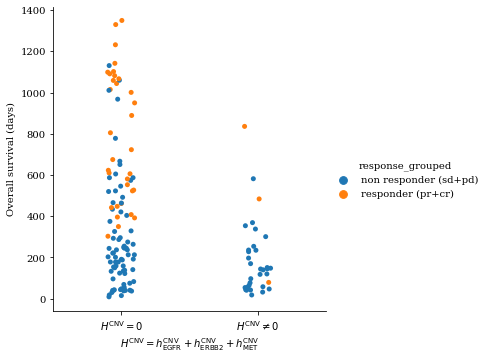

In [56]:
plt.rc('font', family='serif')
fig = plt.figure(figsize=(4, 3))

sns.catplot(y='OS_days', x=r'H', hue='response_grouped', data=Xy)
plt.ylabel('Overall survival (days)')
label_eq = r'$H^{\mathrm{CNV}} = h^{\mathrm{CNV}}_{\mathrm{EGFR}} + h^{\mathrm{CNV}}_{\mathrm{ERBB2}} + h^{\mathrm{CNV}}_{\mathrm{MET}}$'
plt.xlabel(label_eq)
# plt.tight_layout()
plt.savefig('figs/cnv_patients.png')

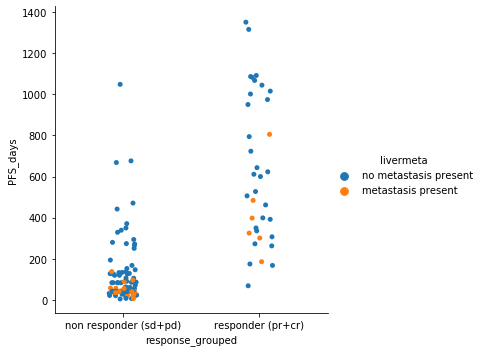

In [12]:
sns.catplot(y='PFS_days', x='response_grouped', hue='livermeta', data=Xy)

# SNV

In [95]:
def count_increasing_mutations(X, y):   
    clinical_columns = [
        "gender",
        "leeftijd",
        "stage",
        "therapyline",
        "smokingstatus",
        "Systemischetherapie",
        "histology_grouped",
        "lymfmeta",
        "brainmeta",
        "adrenalmeta",
        "livermeta",
        "lungmeta",
        "skeletonmeta",
    ]
    genetic_columns = list(set(X.columns) - set(clinical_columns))
    X['increasers'] = X[genetic_columns].sum(axis=1)
    Xy = X.merge(y, left_index=True, right_index=True)
    return Xy

In [96]:
# Harmonic mean genomic variable.
X_train_sign_mol, y_train_sign = combine_tsv_files(
    "output/train__sign__No. Mutant Molecules per mL.tsv",
    "output/train__sign__CNV Score.tsv",
)
Xy_sign_mol = count_increasing_mutations(X_train_sign_mol, y_train_sign)

In [143]:
def calculate_slopes(Xy):
    non_responder = Xy['response_grouped'] == 'non responder (sd+pd)'
    slope_non_resp, int_non_resp, _, p_non_resp, _ = stats.linregress(Xy.loc[non_responder, 'increasers'], Xy.loc[non_responder, 'OS_days'])
    slope_resp, int_resp, _, p_resp, _ = stats.linregress(Xy.loc[~non_responder, 'increasers'], Xy.loc[~non_responder, 'OS_days'])
    slope_all, int_all, _, p_all, _ = stats.linregress(Xy['increasers'], Xy['OS_days'])
    print('non_responder slope', slope_non_resp, '(p={})'.format(p_non_resp))
    print('responder slope', slope_non_resp, '(p={})'.format(p_resp))
    print('response all', slope_all, '(p={})'.format(p_all))
    return slope_all, int_all

non_responder slope -5.838054060715607 (p=0.19119194891136548)
responder slope -5.838054060715607 (p=0.8962908876781793)
response all -13.195562959913559 (p=0.025914704117316868)


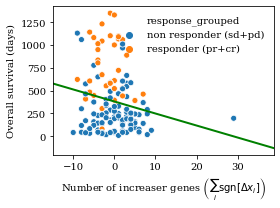

In [168]:
a, b = calculate_slopes(Xy_sign_mol)

plt.rc('font', family='serif')
fig = plt.figure(figsize=(4, 3))
c = sns.scatterplot(y='OS_days', x=r'increasers', hue='response_grouped', data=Xy_sign_mol)
xlim = np.array(plt.xlim()) * 1.25
plt.plot(xlim, xlim*a+b, '-g', linewidth=2)
plt.xlim(xlim)
plt.xlabel(r'Number of increaser genes $\left(\sum_i \mathrm{sgn}[\Delta x_i]\right)$')
plt.ylabel('Overall survival (days)')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('figs/number_of_increasers.png')


In [105]:
# Harmonic mean genomic variable.
X_train_sign_af, y_train_sign = combine_tsv_files(
    "output/train__sign__Allele Fraction.tsv",
    "output/train__sign__CNV Score.tsv",
)
Xy_sign_af = count_increasing_mutations(X_train_sign_af, y_train_sign)

non_responder slope -5.838054060715607 (p=0.19119194891136548)
responder slope -5.838054060715607 (p=0.8962908876781793)
response all -13.195562959913559 (p=0.025914704117316868)


<Figure size 288x216 with 0 Axes>

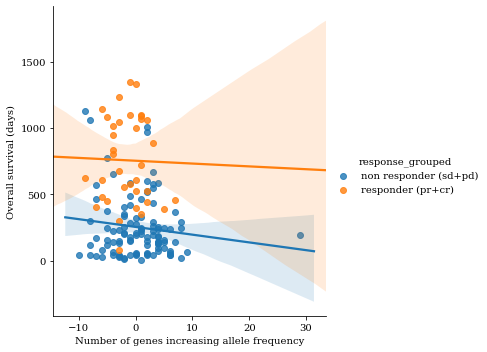

In [131]:
plt.rc('font', family='serif')
fig = plt.figure(figsize=(4, 3))
c = sns.lmplot(y='OS_days', x=r'increasers', hue='response_grouped', data=Xy_sign_af)
plt.xlabel('Number of genes increasing allele frequency')
plt.ylabel('Overall survival (days)')

calculate_slopes(Xy_sign_af)